# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 3:  Regularization and Cross-Validation

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [8pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).


### Answers

**1.1 Load the dataset from the csv file...**

In [4]:
# load the data
bikes_df_raw = pd.read_csv("./data/BSS_hour_raw.csv")
# take a look at the data
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


**Comment:** the values look reasonable

In [5]:
# check data types
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

**Comment: ** The date object is "object", not the right type.

In [6]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [7]:
# check for nulls in the dataset
bikes_df_raw[bikes_df_raw.isnull().any(axis=1)]

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered


**Comment:** The data type for the date column is not correct. All the columns have reasonable data types and range. Rows have no nulls.


**1.2 Notice that the variable in column...**

In [8]:
# change the data type of the date column 
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])

In [9]:
# confirm the new datatype
bikes_df_raw.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

**Comment:** The datetime column is now the correct format.

**1.3 Create three new columns in the dataframe:...**

In [10]:
# add year
bikes_df_raw['year'] = bikes_df_raw['dteday'].dt.to_period('Y')
# add month
bikes_df_raw['month'] = pd.DatetimeIndex(bikes_df_raw['dteday']).month
# add counts
bikes_df_raw['count'] = bikes_df_raw['casual'] + bikes_df_raw['registered']
# confirm year and month were added
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,1,1


---

In [11]:
# check for nulls in the dataset
bikes_df_raw[bikes_df_raw.isnull().any(axis=1)]

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count


**Comment:** Year, month and count seem to have been added correctly. No unexpected nulls either.

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` (please use the copy provided to you in `data/bikes_by_day.csv` for consistency and easy checking) to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') in the original hourly dataset into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 


### Answers

**2.1 Make a new dataframe...**

In [12]:
bikes_by_day_subset = bikes_df_raw.drop(columns=['hour','holiday','workingday','year', 'month'])
bikes_by_day_subset.head()

,dteday,season,weekday,weather,temp,atemp,hum,windspeed,casual,registered,count
0,2011-01-01,1,6,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,6,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,6,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,6,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,6,1,0.24,0.2879,0.75,0.0,0,1,1


In [13]:
bikes_by_day = bikes_by_day_subset.groupby('dteday').agg({'weekday': 'max',
                                                          'weather': 'max',
                                                          'season': 'max',
                                                          'temp': 'mean',
                                                          'atemp': 'mean',
                                                          'windspeed': 'mean',
                                                          'hum' : 'mean',
                                                          'casual': 'sum', 
                                                          'registered': 'sum',
                                                          'count': 'sum'
                                                         })
bikes_by_day.head()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,count
dteday,,,,,,,,,,
2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


**2.2 Use `bikes_by_day` to visualize how the distribution** of total number of rides per day (casual and registered riders combined) varies with the season. Do you see any outliers? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help).

In [14]:
bikes_by_day = pd.read_csv("./data/bikes_by_day.csv")
bikes_by_day.head()

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
0,2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833,1
1,2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087,0
2,2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273,0
3,2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435,0
4,2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957,0


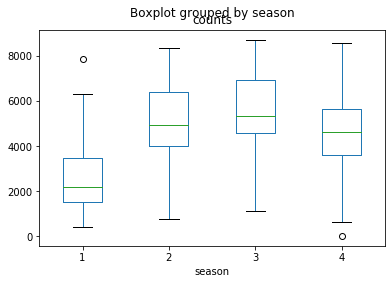

In [15]:
# boxplot by season
bikes_by_day.boxplot(column='counts', by='season', grid = False)

In [16]:
import scipy as sp
season1 = bikes_by_day[bikes_by_day['season'] == 1]
quantiles = season1['counts'].quantile([0.25,0.5,0.75])
quantiles

0.25    1538.0
0.50    2209.0
0.75    3456.0
Name: counts, dtype: float64

In [17]:
# any value 1.5 times the IQR above the 75th percentile
outlier_high_s1 = 3456 + 1.5*(3456-1538)
print("Number of outliers in season 1:", len(season1[season1['counts'] > outlier_high_s1]))
print("Top 5 outliers in season1:")
season1[season1['counts'] > outlier_high_s1 ].head()


Number of outliers in season 1: 1
Top 5 outliers in season1:


,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
441,2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833,1


In [18]:
season4 = bikes_by_day[bikes_by_day['season'] == 4]
quantiles = season4['counts'].quantile([0.25,0.5,0.75])
quantiles

0.25    3615.5
0.50    4634.5
0.75    5624.5
Name: counts, dtype: float64

In [19]:
# any value 1.5 times the IQR above the 75th percentile
# @ Sunil. This feels too manual. It'd be better to have a systemic solution for this
outlier_low_s4 = 3615.5 - 1.5*(5624.5-3615.5)
print("Number of outliers in season 4:", len(season4[season4['counts'] <= outlier_low_s4]))
print("Top 5 outliers in season1:")
season4[season4['counts'] <= outlier_low_s4].head()

Number of outliers in season 4: 1
Top 5 outliers in season1:


,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
667,2012-10-29,22,2,3,20,4,1,0.3582,0.44,0.4394,0.88,0


**Comments** <BR>
March 17, 2012 was a clear (high) outlier in the winter of 2012. That day was St. Patrick's day. It seems reasonable that there were more bike rides, particularly since the weather was nice.
Ocotber 29,2012 was a clear (low) outlier in the autumn of 2012. That day was the day Hurricane Sandy made landfall on the east coast. It seems resonable that bike rides were low that day.

**2.3 Convert the categorical  ('season', 'month', 'weekday', 'weather') attributes** in the original hourly dataset into multiple binary attributes using one-hot encoding and call this new dataframe bikes_df.

In [20]:
bikes_ds = pd.get_dummies(data=bikes_df_raw, columns=['season', 'month', 'weekday', 'weather'])
bikes_ds.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,1,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split** (call them bikes_train and bikes_test, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Use random_state=90, a test set size of .5, and stratify on month. Remember to specify the data's index column as you read it in.


In [21]:
# We'll first split the dataset with stratification on month, then redo hot encoding
bikes_train, bikes_test = train_test_split(bikes_df_raw, 
                                           test_size=0.5, 
                                           stratify = bikes_df_raw['month'],
                                           random_state=90)
bikes_train = pd.get_dummies(data=bikes_train, columns=['season', 'month', 'weekday', 'weather'])
bikes_test = pd.get_dummies(data=bikes_test, columns=['season', 'month', 'weekday', 'weather'])
"# @ Sunil renaming the columns would probably be better"
bikes_train.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_1,weather_2,weather_3,weather_4
17280,2012-12-27,21,0,1,0.24,0.2273,0.60,0.2537,12,51,...,0,0,0,1,0,0,0,1,0,0
6747,2011-10-13,17,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,1,0,0,0,0,1,0
13948,2012-08-09,9,0,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,1,0,0,1,0,0,0
11005,2012-04-08,17,0,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,1,0,0,0
9322,2012-01-29,8,0,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,1,0,0,0


**2.5 Although we asked you to create your train and test set** , for consistency, we ask that for the rest of this problem set you use the train and test set provided in the files data/BSS_train.csv and data/BSS_test.csv. Read these two files into dataframes BSS_train and BSS_test, respectively. Remove the dteday column from both the train and the test dataset (its format cannot be used for analysis).

2.6 Make a plot showing the average number of casual and registered riders during each hour of the day. .groupby and .aggregate should make this task easy. Comment on the trends you observe.

In [64]:
BSS_train = pd.read_csv("./data/BSS_train.csv")
BSS_test = pd.read_csv("./data/BSS_test.csv")
columns_to_drop = ['dteday']
BSS_train = BSS_train.drop(columns_to_drop, axis=1)
BSS_test = BSS_test.drop(columns_to_drop, axis=1)
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


**2.6 Make a plot showing the _average_ number of casual and registered riders** during each hour of the day. .groupby and .aggregate should make this task easy. Comment on the trends you observe.

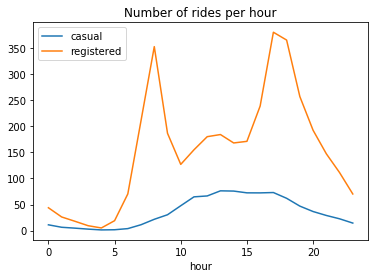

In [65]:
avg_riders_per_hour = BSS_train.groupby('hour').agg({'casual': 'mean',
                                                     'registered': 'mean',
                                                    })
avg_riders_per_hour.plot(title='Number of rides per hour')



**Comment:** It seems reasonable to state that registered and casual riders behave differently. Registered riders peak on morning and evening rides. It would be logical to assume these registered users commute by bike. Teh casual users seem to use the bikes mostly during the day. Overall registered users use the bike services multiple times more frequently.


---

<div class='exercise'> <b> Question 3 [25pts]: Linear Regression to Model Hourly Ridership </b> </div>

**3.1** Use a linear regression model to formally test (via a probabilistic-based hypothesis test) whether `counts` is significantly different in the summer than the other months combined.  Be sure to interpret the results.  

**3.2** Use a resampling method to determine whether `counts` is significantly different in the summer than the other months combined.  How do these results compare to **3.1**?

**3.3** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was directly derived from and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.4** Examine the estimated coefficients and report which ones are statistically significant (at a significance level of $\alpha = 0.05$). 

**3.5** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.6** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


### Answers

**3.1 Use a linear regression model to formally test** (via a probabilistic-based hypothesis test) whether counts is significantly different in the summer than the other months combined. Be sure to interpret the results.

In [66]:
BSS_train = pd.read_csv("./data/BSS_train.csv")
BSS_test = pd.read_csv("./data/BSS_test.csv")
columns_to_drop = ['dteday']
BSS_train = BSS_train.drop(columns_to_drop, axis=1)
BSS_test = BSS_test.drop(columns_to_drop, axis=1)
BSS_train.head()

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'counts', 'spring', 'summer',
       'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy',
       'Snow', 'Storm'],
      dtype='object')

In [69]:
# add intercept, taking into account both regressors
OLS_x_train = sm.tools.add_constant(BSS_train[['hour','spring', 'summer','fall']])
OLS_x_test = sm.tools.add_constant(BSS_test[['hour','spring', 'summer','fall']])

# limit the target variable to pickup count for both the train and test dataset
y_train = BSS_train['counts']
y_test = BSS_test['counts']

In [71]:
# fit the model on the training data
OLSModel = OLS(y_train,OLS_x_train).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     635.5
Date:                Sat, 10 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:14:49   Log-Likelihood:                -56404.
No. Observations:                8689   AIC:                         1.128e+05
Df Residuals:                    8684   BIC:                         1.129e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9673      4.484     -2.446      0.014     -19.756      -2.179
hour          10.3022      0.246     41.869      0.000       9.820      10.785
spring       105.2587      4.858     21.668      0.000      95.736     114.781
summer       127.5051      4.816     26.477      0.000     118.065     136.945
fall          92.1813      4.890     18.849      0.000      82.595     101.768
==============================================================================
Omnibus:                     1800.732   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3555.216
Skew:                           1.250   Prob(JB):                         0.00
Kurtosis:                       4.890   Cond. No.                         60.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*your answer here*

**3.2 Use a resampling method to determine whether counts is** significantly different in the summer than the other months combined. How do these results compare to 3.1?

In [81]:
combined = BSS_train.append(BSS_test, ignore_index=True)

In [89]:
BSS_train_resample, BSS_test_resample = train_test_split(combined, test_size=0.8, random_state=90)

# add intercept, taking into account both regressors
OLS_x_train_resample = sm.tools.add_constant(BSS_train_resample[['hour','spring', 'summer','fall']])
OLS_x_test_resample = sm.tools.add_constant(BSS_test_resample[['hour','spring', 'summer','fall']])

# limit the target variable to pickup count for both the train and test dataset
y_train_resample = BSS_train_resample['counts']
y_test_resample = BSS_test_resample['counts']

# fit the model on the training data
OLSModel_resample = OLS(y_train_resample, OLS_x_train_resample).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel_resample.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     241.7
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          2.46e-183
Time:                        16:25:12   Log-Likelihood:                -22590.
No. Observations:                3475   AIC:                         4.519e+04
Df Residuals:                    3470   BIC:                         4.522e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7115      7.188     -0.655      0.512     -18.805       9.382
hour          10.3650      0.398     26.016      0.000       9.584      11.146
spring        96.6467      7.779     12.424      0.000      81.394     111.899
summer       124.2697      7.736     16.064      0.000     109.102     139.437
fall          78.1425      7.884      9.911      0.000      62.684      93.600
==============================================================================
Omnibus:                      762.900   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1542.716
Skew:                           1.298   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                         60.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*your answer here*

**3.3 Use statsmodels to fit a multiple linear regression model** to the training set using all the useable predictors (nothing that count was directly derived from and no interactions or polynomial terms) to predict counts, and report its  𝑅2  score on the train and test sets. Call this set of predictors X_train.



In [72]:
trivial_cols = ['casual','registered']

BSS_train = BSS_train.drop(trivial_cols, axis=1)
BSS_test = BSS_test.drop(trivial_cols, axis=1)

BSS_test.columns

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,2,0,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,139,1,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,226,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,43,0,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,130,0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
# add intercept, taking into account both regressors
OLS_x_train = sm.tools.add_constant(BSS_train.loc[:, BSS_train.columns != 'counts'])
OLS_x_test = sm.tools.add_constant(BSS_test.loc[:, BSS_test.columns != 'counts'])

# limit the target variable to pickup count for both the train and test dataset
y_train = BSS_train['counts']
y_test = BSS_test['counts']

In [74]:
# fit the model on the training data
OLSModel_all_pred = OLS(y_train,OLS_x_train).fit()
print("Statmodels results: \n",OLSModel_all_pred.params,sep="")

OLSModel_all_pred.summary()

Statmodels results: 
const         -30.407500
hour            7.209247
holiday       -19.151036
year           78.121108
workingday     10.948441
temp          273.662515
atemp         162.535266
hum          -202.008009
windspeed      19.382705
spring         50.075412
summer         22.687920
fall           70.947417
Feb           -10.719770
Mar           -11.293840
Apr           -44.832594
May           -50.160547
Jun           -72.204151
Jul           -90.896453
Aug           -58.324552
Sept          -16.168637
Oct           -15.883815
Nov           -32.723179
Dec           -19.208751
Mon            -3.333610
Tue            -0.007375
Wed            -2.205852
Thu            -5.569800
Fri             2.914043
Sat            12.746077
Cloudy          6.916314
Snow          -26.815450
Storm          48.204539
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Sat, 10 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:17:06   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [78]:
predicted_y = OLSModel_all_pred.predict(OLS_x_test)

r2 = np.corrcoef(y_test, predicted_y)[0, 1]**2 
print(r2)

0.4009432506516229


**3.4 Examine the estimated coefficients and report** which ones are statistically significant (at a significance level of $\alpha = 0.05$). 

In [28]:
'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 'counts', 'spring', 'summer', 'fall',  'Apr', 
'May', 'Jun', 'Jul', 'Aug', 'Nov', 'Dec',  'Sat',  'Snow',

**3.5 You should see some strange estimates for the predictors representing months.**  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

*your answer here*

**All the month coeffients are negetative and for July its highest at -90 suggesting for the month of July we should expect less ridership** 

**There might be multicollinearity problems with season and months leading to a negetative coeffients**

**3.6 To diagnose the model, make two plots:** first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


In [94]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(OLSModel_all_pred)

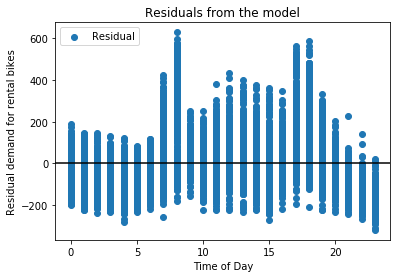

In [96]:
plt.scatter(OLS_x_train['hour'], influence.resid, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals from the model")
plt.ylabel("Residual demand for rental bikes")
plt.xlabel("Time of Day")
plt.legend();

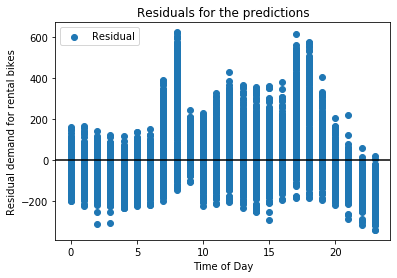

In [97]:
residual = y_test - predicted_y
plt.scatter(OLS_x_test['hour'], residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the predictions")
plt.ylabel("Residual demand for rental bikes")
plt.xlabel("Time of Day")
plt.legend();

*your answer here*


---

<div class='exercise'> <b> Question 4 [22pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` and `BSS_test` (if any of them still remain) to reduce the collinearity in the predictor space.  The variables that remain should be: 

`['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
  'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with `degree=2` you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the numeric predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a numeric feature times a month of weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For polynomials of `degrees = [3,6,9,12,15,18]`:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Which model would you select, and why?

### Answers

**4.1 Drop** the variables workingday, atemp, spring, summer, fall, and dteday from BSS_train and BSS_test (if any of them still remain) to reduce the collinearity in the predictor space. The variables that remain should be:

['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
  'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

In [30]:
# drop columns to reduce collinearity
BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer','fall'], axis=1)
BSS_test = BSS_test.drop(['workingday', 'atemp', 'spring', 'summer','fall'], axis=1)
BSS_train.head()

,hour,holiday,year,temp,hum,windspeed,counts,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,0.24,0.60,0.2537,63,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,0.62,0.83,0.2537,479,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,0.76,0.66,0.1642,353,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0.62,0.22,0.2985,411,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0.18,0.40,0.1343,70,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**4.2 Write a function to standardize** a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from X_train into a dataset called practice_X_train and scaling only those columns. Call the result practice_X_train_scaled. Display the .describe() and verify that you have correctly scaled all columns.

Hint: employ the provided list of binary columns and use pd.columns.difference()

binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']

In [31]:
######
# your code here
######

def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    # subset the data to the columns to scale
    train_data_to_scale = train_data[cols_to_scale]
    test_data_to_scale = train_data[cols_to_scale]
    # calculate mean and standard deviation of the training set
    train_data_to_scale_means = train_data_to_scale.mean()    
    train_data_to_scale_stdev = train_data_to_scale.std()
    
    # standardize the data
    train = (train_data_to_scale - train_data_to_scale_means)/train_data_to_scale_stdev
    # we leverage the mean and stdev of the training set to standardize the test set
    test = (test_data_to_scale - train_data_to_scale_means)/train_data_to_scale_stdev
    return train, test

In [32]:
BSS_train.describe()

,hour,holiday,year,temp,hum,windspeed,counts,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,11.597537,0.029347,0.503395,0.496405,0.625256,0.190616,190.381517,0.077224,0.084705,0.082748,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,6.960206,0.168788,0.500017,0.192561,0.192281,0.123252,181.432185,0.266962,0.278458,0.275517,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.340000,0.480000,0.104500,40.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,1.000000,0.500000,0.620000,0.194000,144.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.000000,1.000000,0.660000,0.780000,0.253700,284.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,1.000000,1.000000,0.980000,1.000000,0.850700,977.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
binary_columns = [ 'holiday', 'workingday',
                  'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 
                  'spring', 'summer', 'fall', 
                  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 
                  'Cloudy', 'Snow', 'Storm']
practice_X_train = BSS_train[BSS_train.columns.difference(binary_columns)]
practice_X_test = BSS_test[BSS_train.columns.difference(binary_columns)]
practice_X_train.describe()

,counts,hour,hum,temp,windspeed,year
count,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,190.381517,11.597537,0.625256,0.496405,0.190616,0.503395
std,181.432185,6.960206,0.192281,0.192561,0.123252,0.500017
min,1.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,40.000000,6.000000,0.480000,0.340000,0.104500,0.000000
50%,144.000000,12.000000,0.620000,0.500000,0.194000,1.000000
75%,284.000000,18.000000,0.780000,0.660000,0.253700,1.000000
max,977.000000,23.000000,1.000000,0.980000,0.850700,1.000000


**Comment:** note how all the non-binary features (left of Feb) are not standardized. The mean is not zero. Standard deviation is not 1.

In [34]:
practice_X_train_scaled, practice_X_train_test_scaled = scale_datasets(practice_X_train, practice_X_test, ['hour',
                                                              'year',
                                                              'temp',
                                                              'hum',
                                                              'windspeed',
                                                              'counts'
                                                              ])

practice_X_train_scaled.describe()

,hour,year,temp,hum,windspeed,counts
count,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03
mean,7.326526e-17,1.077015e-15,1.180187e-14,3.874411e-14,7.452489e-14,6.602051e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.666263e+00,-1.006755e+00,-2.474050e+00,-3.251787e+00,-1.546547e+00,-1.043814e+00
25%,-8.042200e-01,-1.006755e+00,-8.122357e-01,-7.554373e-01,-6.986934e-01,-8.288580e-01
50%,5.782341e-02,9.931755e-01,1.867126e-02,-2.733539e-02,2.745877e-02,-2.556411e-01
75%,9.198668e-01,9.931755e-01,8.495782e-01,8.047811e-01,5.118307e-01,5.159971e-01
max,1.638236e+00,9.931755e-01,2.511392e+00,1.948941e+00,5.355550e+00,4.335606e+00


**Comment:** note how all the non-binary features are now standardized. The mean is (very close to) zero. Standard deviation is 1.

In [35]:
#@Sunil not sure what they want us to do with this function
def split_columns(df, target_col, drop_columns):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """

    return X_train, y_train

**4.3 Write a code to augment your a dataset with higher-order features** for temp, hum,windspeed, and hour. You should include ONLY the pure powers of these columns. So with degree=2 you should produce temp^2 and hum^2 but not temp*hum or any other two-feature interactions.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing practice_X_train_poly, a training dataset with quadratic and cubic features built from practice_X_train_scaled, and printing practice_X_train_poly's column names and .head().

In [36]:
def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    # walk through the columns for which to add polynomials
    for column in columns:
        # create 2+ degree polynomials
        for polynomial in range(degree):
            # ignore polynomials with exponent 0 and 1
            polynomial = polynomial + 2
            if polynomial <= degree:
                # create the new columns
                dataset[str(column) + "_" + str(polynomial)] = dataset[column] ** polynomial
    poly_dataset = dataset
    return poly_dataset

In [37]:
practice_X_train_poly = add_poly_features(practice_X_train_scaled, 3, ['temp','hum','windspeed','hour'])
print("The columns in the practice_X_train_poly dataset:\n",practice_X_train_poly.columns)
practice_X_train_poly.head()

The columns in the practice_X_train_poly dataset:
 Index(['hour', 'year', 'temp', 'hum', 'windspeed', 'counts', 'temp_2',
       'temp_3', 'hum_2', 'hum_3', 'windspeed_2', 'windspeed_3', 'hour_2',
       'hour_3'],
      dtype='object')


,hour,year,temp,hum,windspeed,counts,temp_2,temp_3,hum_2,hum_3,windspeed_2,windspeed_3,hour_2,hour_3
0,1.350889,0.993176,-1.331553,-0.131350,0.511831,-0.702089,1.773032,-2.360885,0.017253,-0.002266,0.261971,0.134085,1.824900,2.465236
1,0.776193,-1.006755,0.641851,1.064817,0.511831,1.590779,0.411973,0.264426,1.133836,1.207329,0.261971,0.134085,0.602475,0.467637
2,-0.373198,0.993176,1.368895,0.180694,-0.214322,0.896304,1.873874,2.565136,0.032650,0.005900,0.045934,-0.009845,0.139277,-0.051978
3,0.776193,0.993176,0.641851,-2.107627,0.875312,1.215983,0.411973,0.264426,4.442090,-9.362266,0.766172,0.670640,0.602475,0.467637
4,-0.516872,0.993176,-1.643143,-1.171496,-0.456913,-0.663507,2.699918,-4.436350,1.372402,-1.607762,0.208770,-0.095390,0.267157,-0.138086


These results look reasonable: squared and cubed versions have been added.

**4.4 Write code to add interaction terms to the model.** Specifically, we want interactions between the numeric predictors (temp, hum,windspeed) and the month and weekday dummies (Feb, Mar...Dec, Mon, Tue, ... Sat). That means you SHOULD build temp*Feb and hum*Mon and so on, but NOT Feb*Mar and NOT Feb*Tue. The interaction terms should always be a continuous feature times a month dummy or a numeric feature times a month of weekday dummy.

In [38]:
BSS_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [39]:
######
# your code here
######

def build_interaction(df, interact_left, interact_right):
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    # pairwise walk through the columns
    for left in interact_left:
        for right in interact_right:
            # create an interaction column by multiplying the numbers
            df[str(left) + str(right)] = df[left] * df[right]
    result_df = df
    return result_df

In [40]:
interaction_set_1 = ['temp','hum','windspeed']
interaction_set_2 = ['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec',
                     'Mon','Tue','Wed','Thu','Fri','Sat']
BSS_train_test_interact = build_interaction(BSS_train, interaction_set_1, interaction_set_2)
print(BSS_train.columns)
BSS_train_test_interact.head()

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm',
       'tempFeb', 'tempMar', 'tempApr', 'tempMay', 'tempJun', 'tempJul',
       'tempAug', 'tempSept', 'tempOct', 'tempNov', 'tempDec', 'tempMon',
       'tempTue', 'tempWed', 'tempThu', 'tempFri', 'tempSat', 'humFeb',
       'humMar', 'humApr', 'humMay', 'humJun', 'humJul', 'humAug', 'humSept',
       'humOct', 'humNov', 'humDec', 'humMon', 'humTue', 'humWed', 'humThu',
       'humFri', 'humSat', 'windspeedFeb', 'windspeedMar', 'windspeedApr',
       'windspeedMay', 'windspeedJun', 'windspeedJul', 'windspeedAug',
       'windspeedSept', 'windspeedOct', 'windspeedNov', 'windspeedDec',
       'windspeedMon', 'windspeedTue', 'windspeedWed', 'windspeedThu',
       'windspeedFri', 'windspeedSat'],
      dtype='object')


,hour,holiday,year,temp,hum,windspeed,counts,Feb,Mar,Apr,...,windspeedSept,windspeedOct,windspeedNov,windspeedDec,windspeedMon,windspeedTue,windspeedWed,windspeedThu,windspeedFri,windspeedSat
0,21,0,1,0.24,0.60,0.2537,63,0,0,0,...,0.0,0.0000,0.0,0.2537,0.0,0.0,0.0,0.2537,0.0,0.0
1,17,0,0,0.62,0.83,0.2537,479,0,0,0,...,0.0,0.2537,0.0,0.0000,0.0,0.0,0.0,0.2537,0.0,0.0
2,9,0,1,0.76,0.66,0.1642,353,0,0,0,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.1642,0.0,0.0
3,17,0,1,0.62,0.22,0.2985,411,0,0,1,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0
4,8,0,1,0.18,0.40,0.1343,70,0,0,0,...,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0


**4.5 Combine all your code so far into a function named** get_design_mats that takes in BSS_train, BSS_test, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices X_train and X_test and responses y_train and y_test. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [41]:
######
# your code here
######

def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
 
    return x_train,y_train, x_val,y_val


**4.6 For polynomials of `degrees = [3,6,9,12,15,18]`:** 
1. Build the training design matrix and validation design matrix using the function get_design_mats with polynomial terms up through the specified degree.
2. Fit a regression model to the training data.
3. Report the model's score on the test data.

In [42]:
######
# your code here
######

**4.7 Which model would you select, and why?**

*your answer here*

---

<div class='exercise'> <b> Question 5 [25pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split (use `random_state=109`).  Build a table showing the validation set $R^2$ for the degree-15 polynomial model, regularized at the levels `alphas = np.exp(np.arange(-10,11,1))`. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring Ridge model above.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset (design matrix) with polynomial degree 2 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `alphas = np.exp(np.arange(-10,10,1))`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Build a plot which cleanly presents, for the 'main effect' features: 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso, so that each predictor's coefficient can be easily compared across the 3 models.  These main effect features should be: `['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.6** What differences do you see in the plot above comparing the 3 types of models?  Are any of the results surprising?

### Answers

**5.1 Let's try regularizing our models via...** 

In [43]:
bikes_train, bikes_val = train_test_split(BSS_train, test_size=.2, random_state=109)

In [100]:
bikes_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm',
       'tempFeb', 'tempMar', 'tempApr', 'tempMay', 'tempJun', 'tempJul',
       'tempAug', 'tempSept', 'tempOct', 'tempNov', 'tempDec', 'tempMon',
       'tempTue', 'tempWed', 'tempThu', 'tempFri', 'tempSat', 'humFeb',
       'humMar', 'humApr', 'humMay', 'humJun', 'humJul', 'humAug', 'humSept',
       'humOct', 'humNov', 'humDec', 'humMon', 'humTue', 'humWed', 'humThu',
       'humFri', 'humSat', 'windspeedFeb', 'windspeedMar', 'windspeedApr',
       'windspeedMay', 'windspeedJun', 'windspeedJul', 'windspeedAug',
       'windspeedSept', 'windspeedOct', 'windspeedNov', 'windspeedDec',
       'windspeedMon', 'windspeedTue', 'windspeedWed', 'windspeedThu',
       'windspeedFri', 'windspeedSat'],
      dtype='object')

In [99]:
Xtrain = PolynomialFeatures(15).fit_transform(bikes_train)

KeyboardInterrupt: 

In [98]:
alphas = np.exp(np.arange(-10,11,1))

array([4.53999298e-05, 1.23409804e-04, 3.35462628e-04, 9.11881966e-04,
       2.47875218e-03, 6.73794700e-03, 1.83156389e-02, 4.97870684e-02,
       1.35335283e-01, 3.67879441e-01, 1.00000000e+00, 2.71828183e+00,
       7.38905610e+00, 2.00855369e+01, 5.45981500e+01, 1.48413159e+02,
       4.03428793e+02, 1.09663316e+03, 2.98095799e+03, 8.10308393e+03,
       2.20264658e+04])

In [44]:
######
# your code here
######


**5.2 Find the best-scoring degree and regularization combination.**

In [45]:
######
# your code here
######


**5.3 It's time to see how well our selected model...**


In [46]:
######
# your code here
######

*your answer here*


**5.4 Build a dataset with polynomial degree 1...**

In [47]:
######
# your code here
######

**5.5  Build a plot which cleanly presents, for each feature in the data...**

In [48]:
######
# your code here
######

**5.6 What differences do you see...**

*your answer here*

---